In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Entropy, Cross-Entropy and Kullback-Leibler Divergence

**Entropy**

Given $n$ events with probabilities $p = (p_1, \ldots, p_n)$, the uncertainty or entropy associated with the probability distribution $p$ is:
$$
    H(p) = - \sum_i p_i \cdot \log p_i = \sum_i p_i \cdot \log \frac{1}{p_i}.
$$
Thus $H(p) := \mathbf{E}_{p}[\log \text{surprise}]$.

**Cross-Entropy**

Suppose $p$ and $q$ are two probability distributions over the same set of events. The cross-entropy of $q$ relative to $p$ is defined as:
$$
    H(p, q) = - \mathbf{E}_p[\log q] = - \sum_{i} p_i \cdot \log q_i.
$$

**Kullback-Leibler Divergence $D_{KL}$**

Suppose that $p$ is the true probability distribution of a set of events and that $q$ is an approximation to $p$. The distance $D_{KL}$ of $q$ from $p$ is defined as:
$$
    D_{KL}(p \mid\mid q) = H(p, q) - H(p) = -\sum_i p_i \cdot \log q_i + \sum_i p_i \cdot \log p_i = \sum_i p_i \cdot \log \frac{p_i}{q_i}.
$$

In [2]:
def entropy(p: np.array) -> float:
    return - np.sum(p * np.log(p))

def kullback_leibler(target: np.array, model: np.array) -> float:
    return np.sum(target * (np.log(target) - np.log(model)))

### Code 7.12

In [3]:
entropy(np.array([0.3, 0.7]))

0.6108643020548935

In [4]:
entropy(np.array([0.01, 0.99]))

0.056001534354847345

In [5]:
entropy(np.array([0.7, 0.15, 0.15]))

0.818808456222877

### Figure 7.5

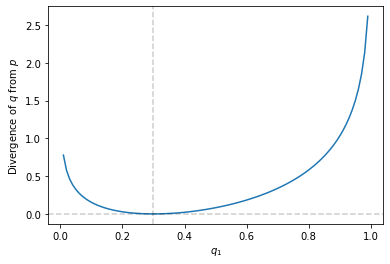

In [6]:
p = np.array([0.3, 0.7])
q_1_vals = np.linspace(0.01, 0.99, 99)
q_2_vals = 1 - q_1_vals

div = []

for q_1, q_2 in zip(q_1_vals, q_2_vals):
    d = kullback_leibler(p, np.array([q_1, q_2]))
    div.append(d)

plt.plot(q_1_vals, div)

plt.axvline(x=0.3, color='k', linestyle='--', alpha=0.2)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.2)

plt.xlabel(r'$q_1$')
plt.ylabel(r'Divergence of $q$ from $p$')

plt.show()

## KL-Divergence is Non-negative

%%latex

Credit: https://stats.stackexchange.com/questions/335197/why-kl-divergence-is-non-negative

We use the fact that $\log a \leq a - 1$ for all $a > 0$. To show that $D_{KL}(p, q) \geq 0$, it is sufficient to show that $- D_{KL}(p, q) \leq 0$. Now 

\begin{array}
~- D_{KL}(p, q) & = - \sum_i p_i \log \frac{p_i}{q_i} \\
               & = \sum_i p_i \log \frac{q_i}{p_i} \\ 
               & \leq \sum_i p_i \left ( \frac{q_i}{p_i} - 1\right ) \\ 
               & = \sum_{i} (q_i - p_i) = 0.
\end{array}


## The Log-Pointwise-Predictive-Density (LPPD)

For data $y = [y_1, \ldots, y_n]$ and a posterior distribution $\Theta$, the LPPD is defined as:
$$
    \mathrm{llpd} (y, \Theta) = \sum_{i = 1}^{n} \log \frac{1}{S} \sum_{s = 1}^{S} p(y_i \mid \Theta_s),
$$

where

* $S$ is the number of samples

* $\Theta_s$ is the set of parameter values corresponding to the $s$th sample from the posterior distribution.

To create the LPPD computation, we recreate the data for the brain-body mass experiments. 

In [7]:
sppnames = ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens']
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]

df = pd.DataFrame({'species': sppnames, 'brain': brainvolcc, 'mass': masskg})

df['mass_std'] = (df['mass'] - df['mass'].mean()) / df['mass'].std()
df['brain_std'] = df['brain'] / df['brain'].max()

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

In [9]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=df).fit()

In [10]:
pd.DataFrame(m_7_1.params)

,0
Intercept,0.528677
mass_std,0.167118


In [11]:
m_7_1.cov_params()

,Intercept,mass_std
Intercept,4.980017e-03,3.981467e-19
mass_std,3.981467e-19,5.810020e-03


### First create the parameters of the distribution

In our case, this amounts to creating the mean and the standard deviations of a multivariate normal distribution from which the coefficients of the linear equation are assumed to be obtained. 
$$
    \text{brain_std} = \alpha + \beta \cdot \text{mass}.
$$

We assume that 
$$
\left ( \begin{array}{c} \alpha \\ \beta \end{array} \right ) \sim N_2 \left ( \mu, \sigma \right ),
$$
where $\mu = (\mu_1, \mu_2)^T$ and $\sigma$ is a $2 \times 2$ covariance matrix.

In [12]:
N_SPECIES = 7
N_SAMPLES = 3000

samples = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(N_SAMPLES) # (N_SAMPLES, 2)

intercept = samples[:, 0] # (N_SAMPLES, )
slope = samples[:, 1] # (N_SAMPLES, )

body_mass_std = df.mass_std.values.reshape(-1, 1)  # (7, 1)
brain_vol_std = df.brain_std.values.reshape(-1, 1)  # (7, 1)

slope = slope.reshape(1, N_SAMPLES)
intercept = intercept.reshape(1, N_SAMPLES)

# broadcasting going on here
pred_means = intercept + body_mass_std * slope  # (7, N_SAMPLES)

# At this point, each column of pred_means is one prediction of the mean values of brain_vol_std 
# for each of the seven species.
# For each sample, take the standard deviations of the brain_vol predictions of all 7 species. 
# This corresponds to taking the standard deviation for the entries of each column (axis=0).

# pred_mean: (7, N_SAMPLES), brain_vol_std: (7, 1) -> broadcasting going on here
sq_diff = (pred_means - brain_vol_std)**2 # (N_SPECIES, N_SAMPLES)
col_wise_sums = np.sum(sq_diff, axis=0) # (N_SAMPLES, )
pred_sigmas = np.sqrt(col_wise_sums / N_SPECIES) # (N_SAMPLES, )

### Next calculate the LPPD for each species

This corresponds to the following steps:

1. Compute the pdf for each sample of parameters from the posterior distribution: $p(y_i \mid \Theta_s)$

2. For each species, take the sum $\sum_s p(y_i \mid \Theta_s)$ over all samples $s$, divide by the number of samples $S$.

3. Finally take logs.

In [13]:
ll = np.zeros(shape=(N_SPECIES, N_SAMPLES))

for s in range(N_SAMPLES):
    ll[:, s] = stats.norm.pdf(x=df.brain_std, loc=pred_means[:, s], scale=pred_sigmas[s])

lppd = np.zeros(N_SPECIES)

for i in range(N_SPECIES):
    lppd[i] = np.log(np.sum(ll[i]) / N_SAMPLES) 
lppd

array([ 0.61846515,  0.65814422,  0.56332749,  0.62659149,  0.4730469 ,
        0.44158766, -0.84481065])

### Alternative

First take the `logpdf`, then their exponents, sum, and finally take logs once more!

In [14]:
ll = np.zeros(shape=(N_SPECIES, N_SAMPLES))

for s in range(N_SAMPLES):
    ll[:, s] = stats.norm.logpdf(x=df.brain_std, loc=pred_means[:, s], scale=pred_sigmas[s])

lppd = np.zeros(N_SPECIES)

for i in range(N_SPECIES):
    lppd[i] = logsumexp(ll[i]) - np.log(N_SAMPLES) 
lppd

array([ 0.61846515,  0.65814422,  0.56332749,  0.62659149,  0.4730469 ,
        0.44158766, -0.84481065])

### LPPD Function

Credit: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_07.ipynb

In [15]:
def lppd(model, df: pd.DataFrame, y: str, ns=10000):
    # First create samples for the model parameters: 
    # (N_PARAMS, ns)
    samples = stats.multivariate_normal(model.params, model.cov_params()).rvs(ns).T  
    
    # get model design matrix
    # (N_SPECIES, N_PARAMS)
    dmat = dmatrix(model.model.data.design_info, 
                   df, 
                   return_type="dataframe").values 
    
    # (N_SPECIES, ns)
    pred = dmat.dot(samples)
    
    N_SPECIES = pred.shape[0]
    
    y_std = df[y].values.reshape(-1, 1)  # (N_SPECIES, 1)
    sq_diff = (pred - y_std)**2 # (N_SPECIES, ns)
    col_wise_sums = np.sum(sq_diff, axis=0) # (ns, )
    sigmas = np.sqrt(col_wise_sums / N_SPECIES) # (ns, )
    
    ll = np.zeros(shape=(N_SPECIES, ns))
    
    for s in range(ns):
        ll[:, s] = stats.norm.logpdf(x=df[y], loc=pred[:, s], scale=sigmas[s])

    lppd = np.zeros(N_SPECIES)

    for i in range(N_SPECIES):
        lppd[i] = logsumexp(ll[i]) - np.log(ns) 
    
    return lppd

In [16]:
lppd(m_7_1, df, "brain_std")

array([ 0.61846218,  0.65735826,  0.55808921,  0.62644948,  0.4768186 ,
        0.44644779, -0.84697239])

In [17]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=df).fit()
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", 
                data=df).fit()
m_7_4 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)" 
                "+ I(mass_std**4)", 
                data=df).fit()
m_7_5 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)"
                " + I(mass_std**4) + I(mass_std**5)", 
                data=df).fit()
m_7_6 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)" 
                "+ I(mass_std**4) + I(mass_std**5) + I(mass_std**6)", 
                data=df).fit()

models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

In [18]:
m_7_6.cov_params()

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


,Intercept,mass_std,I(mass_std ** 2),I(mass_std ** 3),I(mass_std ** 4),I(mass_std ** 5),I(mass_std ** 6)
Intercept,inf,inf,-inf,-inf,inf,inf,-inf
mass_std,inf,inf,-inf,-inf,inf,inf,-inf
I(mass_std ** 2),-inf,-inf,inf,inf,-inf,-inf,inf
I(mass_std ** 3),-inf,-inf,inf,inf,-inf,-inf,inf
I(mass_std ** 4),inf,inf,-inf,-inf,inf,inf,-inf
I(mass_std ** 5),inf,inf,-inf,-inf,inf,inf,-inf
I(mass_std ** 6),-inf,-inf,inf,inf,-inf,-inf,inf


In [19]:
# model 7_6 has an infinite covariance matrix. Not calculating it lppd 

lppd_models = {}

for name, model in zip(names[:-1], models[:-1]):
    lppd_models[name] = np.sum(lppd(model, df, "brain_std"))

lppd_models

{'m_7_1': 2.5185385626699865,
 'm_7_2': 2.340265692339189,
 'm_7_3': 2.8553399841617146,
 'm_7_4': 3.5384360192532505,
 'm_7_5': 11.049199128087146}

## Code for Figure 7.6

In [20]:
from scipy.stats import norm


def create_data(coeffs, num_samples):
    # For the outcome variable to have variance 1, we scale the variances of other variables 
    sigma = 1 # / np.sqrt(len(coeffs))
    x1 = norm.rvs(loc=0, scale=sigma, size=num_samples)
    x2 = norm.rvs(loc=0, scale=sigma, size=num_samples)
    
    y = coeffs[0] * x1 + coeffs[1] * x2
    
    ret = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})
    
    return ret

def create_train_test_data(coeffs=[0.15, -0.4], num_samples=20):
    train_df = create_data(coeffs, num_samples)
    test_df = create_data(coeffs, num_samples)
    
    return train_df, test_df

In [21]:
model_str = {'m1': 'y ~ x1', 
             'm2': 'y ~ x2', 
             'm3': 'y ~ x1 + x2', 
             'm4': 'y ~ x1 + x2 + I(x1 ** 2)', 
             'm5': 'y ~ x1 + x2 + I(x1 ** 2) + I(x2 ** 2)', 
             'm6': 'y ~ x1 + x2 + I(x1 ** 2) + I(x2 ** 2) + I(x1 ** 3)'}

models = {}

train_df, test_df = create_train_test_data()

for k, v in model_str.items():
    models[k] = smf.ols(v, data=train_df).fit()

In [22]:
lppd_models = {}

for name, model in models.items():
    train_lppd = np.sum(lppd(model, train_df, 'y'))
    test_lppd = np.sum(lppd(model, test_df, 'y'))
    lppd_models[name] = [train_lppd, test_lppd]

lppd_models

{'m1': [-10.546075390534197, -7.607259568186322],
 'm2': [12.370719468972354, 8.472819138815801],
 'm3': [689.5589758109321, 690.962745813083],
 'm4': [698.5723915363122, 700.8318039413396],
 'm5': [680.5619726166457, 682.5463757793167],
 'm6': [700.8808907849755, 694.5016668506145]}

<ipython-input-23-79162cc0f60f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names)


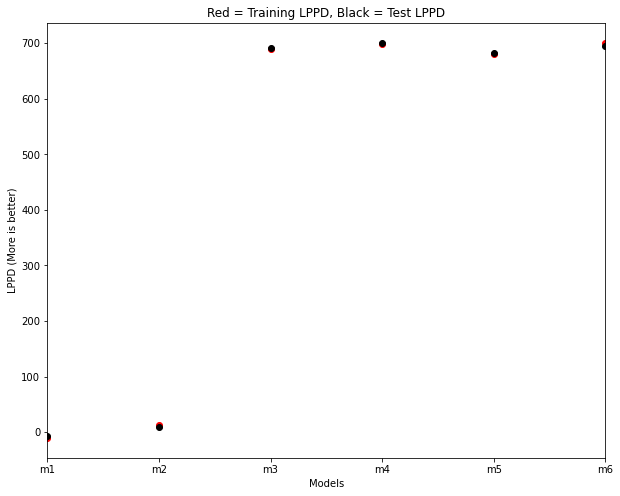

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_names = sorted(model_str.keys())

x_vals = range(1, len(model_names) + 1)

ax.set_ylabel('LPPD (More is better)')
ax.set_xlabel('Models')

ax.set_xlim(left=1, right=len(model_names))

for x, m in enumerate(model_names):
    plt.plot(x + 1, lppd_models[m][0], 'ro')
    plt.plot(x + 1, lppd_models[m][1], 'ko')

ax.set_xticklabels(model_names)

plt.title('Red = Training LPPD, Black = Test LPPD')
plt.show()

<ipython-input-24-23899f844586>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names)


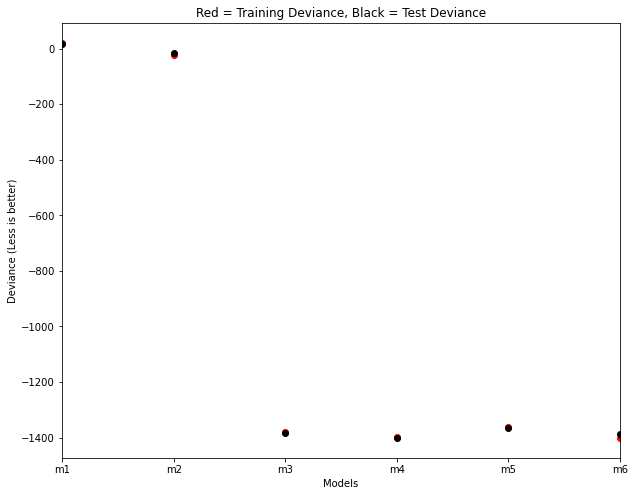

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_names = sorted(model_str.keys())

x_vals = range(1, len(model_names) + 1)

ax.set_ylabel('Deviance (Less is better)')
ax.set_xlabel('Models')

ax.set_xlim(left=1, right=len(model_names))

for x, m in enumerate(model_names):
    plt.plot(x + 1, -2 * lppd_models[m][0], 'ro')
    plt.plot(x + 1, -2 * lppd_models[m][1], 'ko')

ax.set_xticklabels(model_names)

plt.title('Red = Training Deviance, Black = Test Deviance')
plt.show()